# MAGMA experimnetations

## Artificial data : Different HP + Uncommon grid

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Data

In [163]:
N = 100
M = 5

t0 = 10
tN = 20

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [164]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [165]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[51.13379568  2.20593209]


In [166]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [167]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [168]:
Theta = np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T
Sigma = np.random.uniform(0, 1, size=M)

print(Theta)
print(Sigma)

[[109.5679648    1.37788749]
 [ 26.11093994   5.50086   ]
 [ 98.39607235   2.78876468]
 [ 29.7767069    6.32684592]
 [ 75.26172138   3.15151338]]
[0.66970004 0.9736209  0.02806189 0.12566029 0.53963202]


In [169]:
Ni = N //2

T = np.zeros((M, Ni))
Y = np.zeros((M, Ni))

for i in range(M):
    Ti = np.sort(np.random.choice(common_T, size=Ni, replace=False))
    mask = np.isin(common_T, Ti)

    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta[i], Ti)
    Psi_Theta_Sigma = C_Theta + Sigma[i] * np.identity(Ni)

    mu0_i = mu0[mask]
    Yi = np.random.multivariate_normal(mu0_i, Psi_Theta_Sigma)

    T[i] = Ti
    Y[i] = Yi

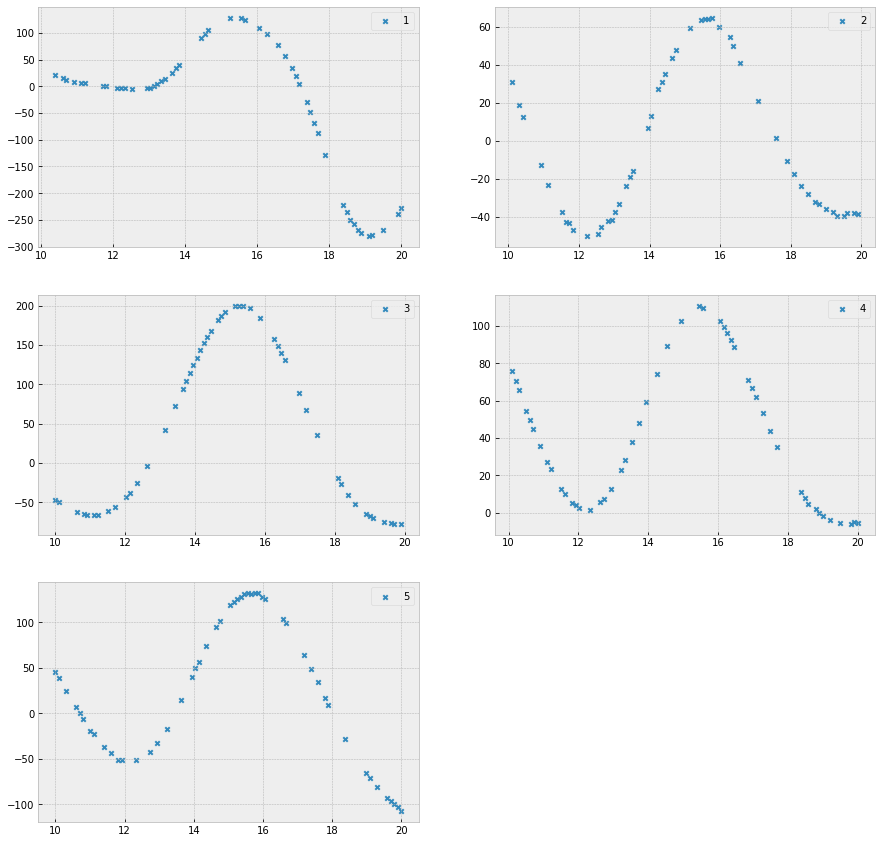

In [170]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.scatter(T[i - 1], Y[i - 1], label=f"{i}",s=20,marker="x")
    plt.legend()
plt.show()

### Model

#### Training

In [171]:
model = MAGMA(
    T=T,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(len(m0)),
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(0.99,1.01), np.random.uniform(0.99,1.01)]),
    Theta=np.array([np.random.uniform(0.99,1.01, size=M), np.random.uniform(0.99,1.01, size=M)]).T,
    Sigma=np.random.uniform(0.49, 0.51, size=M),
    common_hp_flag=False,
    common_grid_flag=False,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [172]:
model.fit(max_iterations=1, eps=1e-2)

MAGMA Training:   0%|          | 0/1 [00:00<?, ?it/s]

theta0
Theta & Sigma 0
Theta & Sigma 1
Theta & Sigma 2
Theta & Sigma 3


MAGMA Training: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

Theta & Sigma 4


In [173]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=1e-4)

MAGMA Training: 100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


In [174]:
history = model.history
len(history)

51

In [175]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

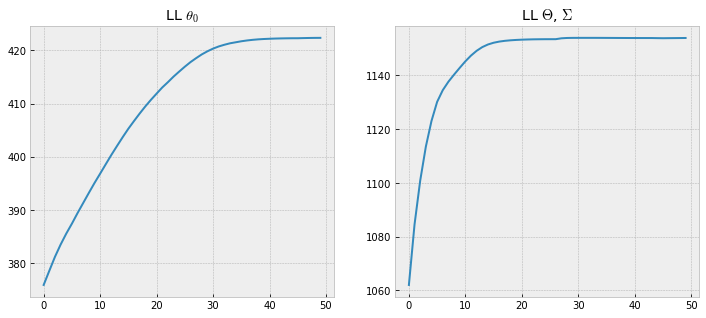

In [176]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [177]:
Sigma_estim = []
for epoch_history in history:
    Sigma_estim.append(epoch_history["Sigma"])
Sigma_estim = np.array(Sigma_estim)
print(model.Sigma)
print(Sigma)

[ 0.77132766  1.00325334  0.14206229 -0.3776415   0.70682801]
[0.66970004 0.9736209  0.02806189 0.12566029 0.53963202]


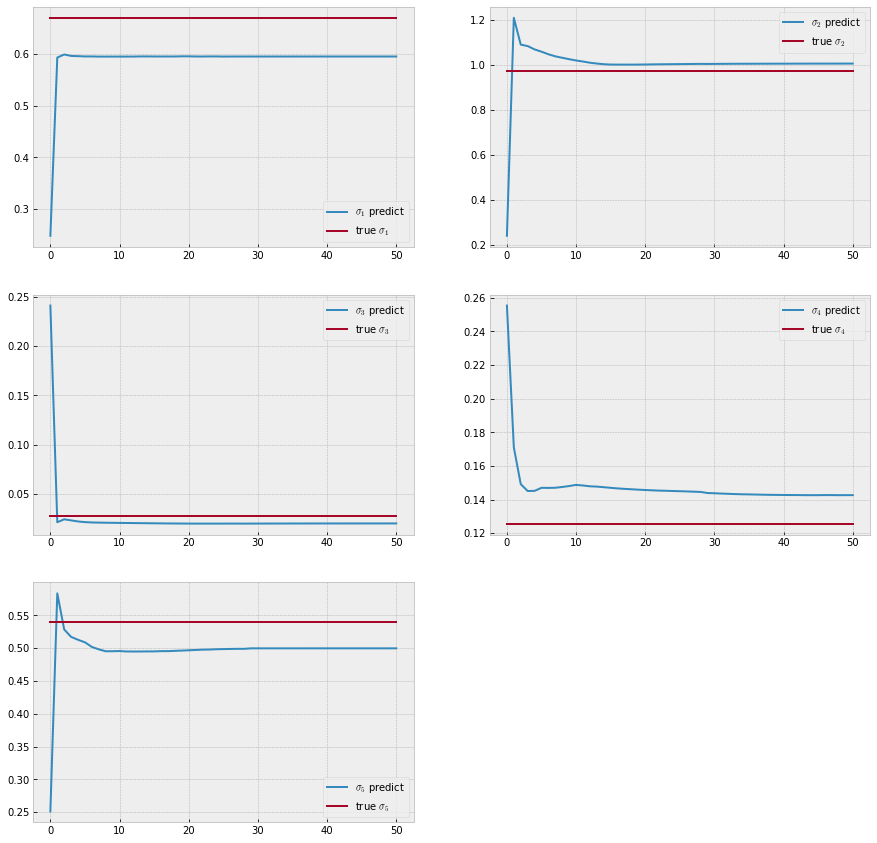

In [178]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Sigma_estim[:, i - 1]**2, label=f"$\sigma_{i}$ predict")
    plt.plot(Sigma[i-1]*np.ones(len(Sigma_estim[:, i - 1])),label=f"true $\sigma_{i}$")
    plt.legend()
plt.show()

In [179]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

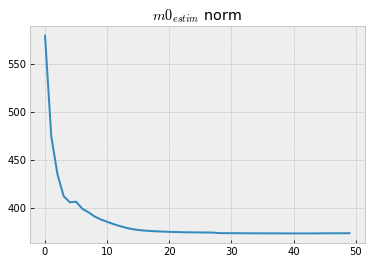

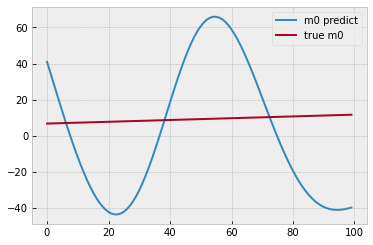

In [180]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()
plt.plot(history[-1]["m0"],label="m0 predict")
plt.plot(m0,label = "true m0")
plt.legend()
plt.show()

In [181]:
theta0_estim = []
for epoch_history in history:
    theta0_estim.append(epoch_history["theta0"])
theta0_estim = np.array(theta0_estim)
print(model.theta0)
print(theta0)

[61.41333086  2.18233071]
[51.13379568  2.20593209]


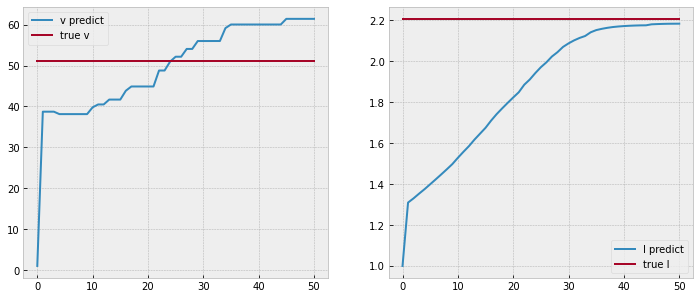

In [182]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0_estim[:, 0], label="v predict")
plt.plot(theta0[0]*np.ones(len(theta0_estim[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(theta0_estim[:, 1], label="l predict")
plt.plot(theta0[1]*np.ones(len(theta0_estim[:, 0])), label="true l")
plt.legend()
plt.show()

In [183]:
Theta_estim = []
for epoch_history in history:
    Theta_estim.append(epoch_history["Theta"])
Theta_estim = np.array(Theta_estim)
print(Theta.shape)
print(model.Theta)
print(Theta)

(5, 2)
[[97.07173865  1.45232547]
 [ 8.95173941  4.31432618]
 [94.89661694  2.80649179]
 [32.1192899   7.92965269]
 [63.57665885  3.03408306]]
[[109.5679648    1.37788749]
 [ 26.11093994   5.50086   ]
 [ 98.39607235   2.78876468]
 [ 29.7767069    6.32684592]
 [ 75.26172138   3.15151338]]


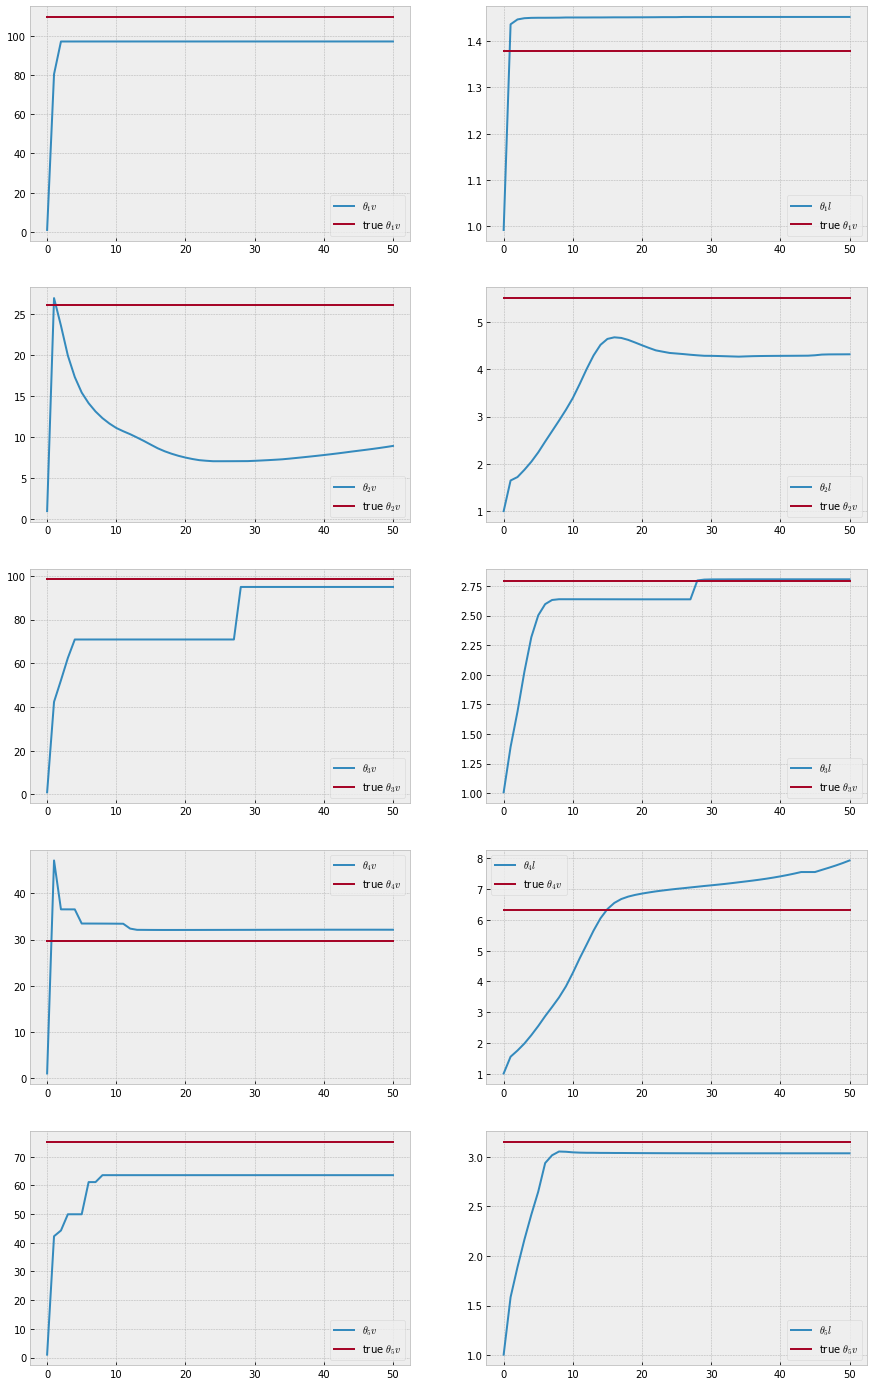

In [184]:
plt.figure(figsize=(15, M * 5))
cpt = 0
for i in range(1, M + 1):
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 0], label=f"$\\theta_{i} v$")
    plt.plot(Theta[i-1,0]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 1], label=f"$\\theta_{i} l$")
    plt.plot(Theta[i-1,1]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
plt.show()

#### Prediction

#### Type II

In [185]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
tObs = 0
T_p_obs = np.linspace(tObs, t0-1e-3, 2*N)
m_p_obs = m0_function(T_p_obs)
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

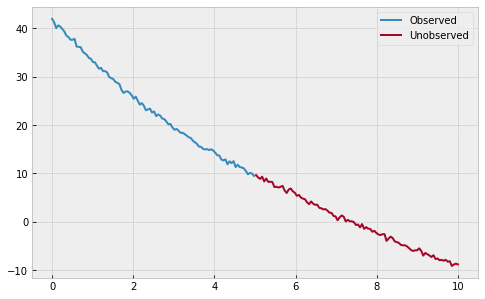

In [186]:
plt.figure(figsize=(8, 5))
plt.plot(T_obs, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [187]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_p, Y_p)

In [188]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

14.667717964599056

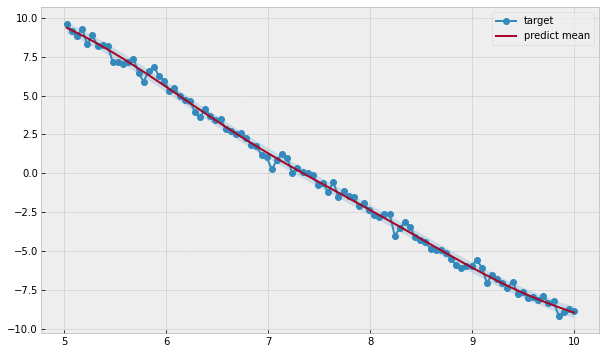

In [189]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

In [190]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_obs, Y_obs)

In [191]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

72.20559557090165

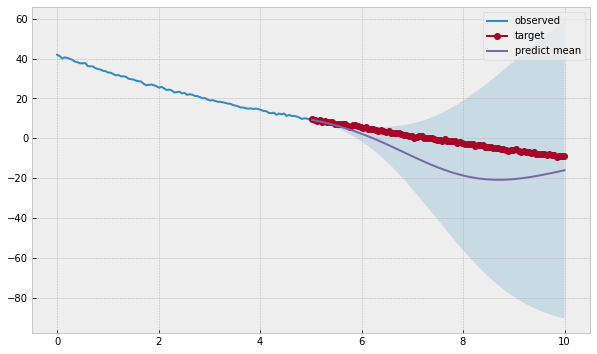

In [192]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

#### Type I

In [193]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
m_p_obs = m0_function(T_p_obs)
T_p_obs = np.concatenate([common_T, np.linspace(tN+1e-3, tN + 10, N)])
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

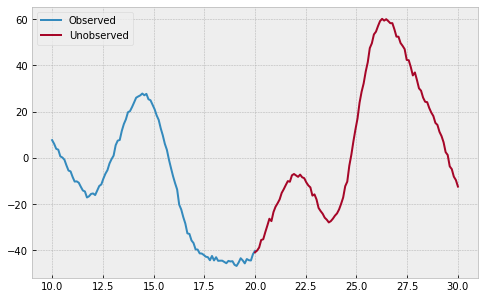

In [194]:
plt.figure(figsize=(8, 5))
plt.plot(common_T, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [195]:
m_P_predict, Cov_P_predict = model.predict(T_p, common_T, Y_obs)

In [196]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

68.07759671092485

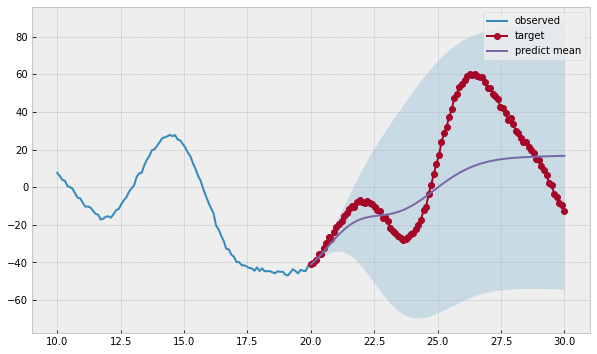

In [197]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()